# Прогнозирование количества заказов такси на следующий час

Заказчик (сервис заказа такси) располагает историческими данными о заказах такси в аэропортах. Для привлечения большего количества водителей в период пиковой нагрузки нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

План работы:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`.

## 1 Подготовка данных

Импортируем все необходимые для работы библиотеки, откроем файл с данными и изучим общую информацию о них.

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# импорт структур и функций
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

# импорт модуля warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# чтение файла с данными и сохранение в таблицу df
df = pd.read_csv('/datasets/taxi.csv', index_col=[0],
                 parse_dates=[0])

# сортировка индекса таблицы
df.sort_index(inplace=True)
# ресемплирование данных по 1 часу
df = df.resample('1H').sum()

# просмотр первых пяти строк полученной таблицы
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [3]:
# просмотр размера таблицы
df.shape

(4416, 1)

In [4]:
# проверка индекса таблицы на монотонность
df.index.is_monotonic

True

In [5]:
# просмотр типа данных
df.dtypes

num_orders    int64
dtype: object

In [6]:
# проверка данных на пропуски
df.isna().sum()

num_orders    0
dtype: int64

In [7]:
# просмотр характерных значений данных
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [8]:
# просмотр минимального и максимального 
# значений индексов данных 
display(df.index.min())
display(df.index.max())

Timestamp('2018-03-01 00:00:00', freq='H')

Timestamp('2018-08-31 23:00:00', freq='H')

### 1.1 Вывод

После ресемплирования в данных 4416 объектов - информация о часовых количествах заказов такси в аэропортах.

Даты и время расположены в хронологическом порядке, тип данных соответствует содержимому по смыслу, пропусков нет.

Минимальное число заказов - 0, максимальное - 462, значения правдоподобны.

В данных представлена информация с 0 часов 1 марта до 23 часов 31 августа 2018 года, т.е. за полгода.

## 2 Анализ данных

У нас есть информация о количестве заказов такси за полгода. Значит, годовые и месячные закономерности мы увидеть не сможем. Но можем увидеть более короткие закономерности, обусловленные неделями, днями и временем суток.

Построим сначала график временного ряда за весь период, добавив в данные столбец со скользящим средним с окном, равным 24, т.е. среднее за сутки.

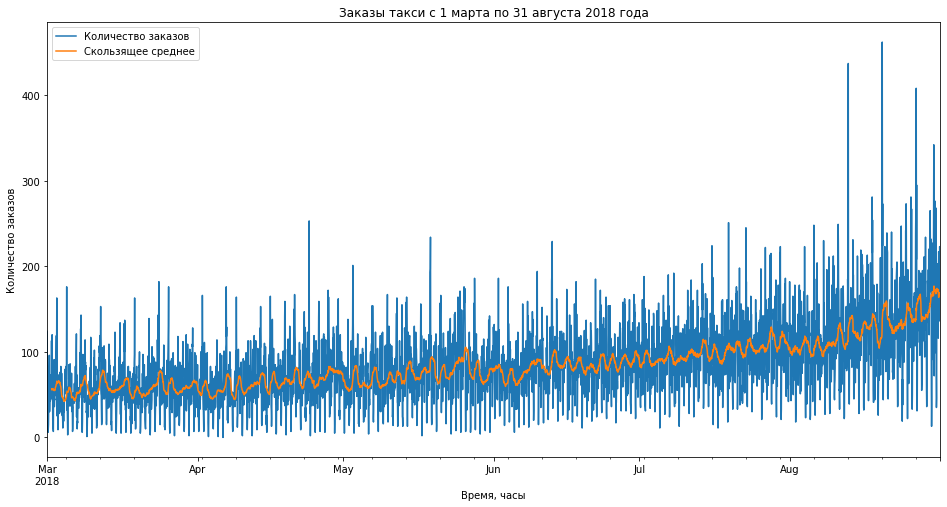

In [9]:
# создание столбца со скользящим средним
df['rolling_mean'] = df['num_orders'].rolling(24).mean()

# построение графика временного ряда
df.plot(figsize=(16, 8))
plt.xlabel('Время, часы')
plt.ylabel('Количество заказов')
plt.title('Заказы такси с 1 марта по 31 августа 2018 года')
plt.legend(['Количество заказов', 'Скользящее среднее'])
plt.show()

По графику видно, что количество заказов во времени колеблется, присутствуют пики. Среднесуточное значение также подвержено колебаниям. В целом, наблюдается небольшой рост количества заказов к концу рассматриваемого полугода. Проверим это с помощью тренда.

Разложим временной ряд на тренд и сезонную компоненту. 

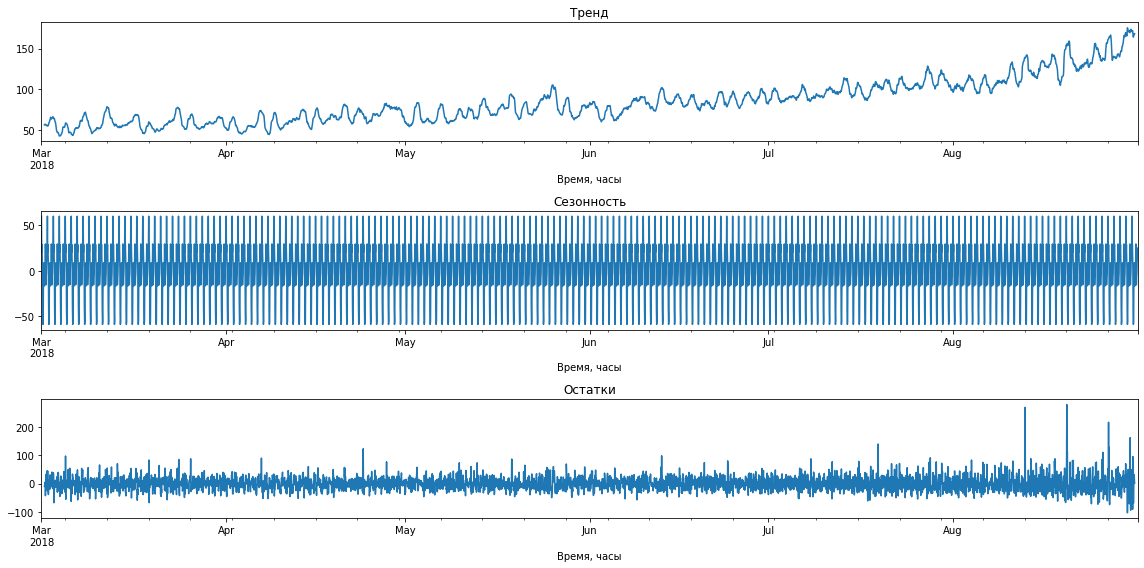

In [10]:
# разложение временного ряда на составляющие
decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(16, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.xlabel('Время, часы')
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.xlabel('Время, часы')
plt.title('Сезонность')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.xlabel('Время, часы')
plt.title('Остатки')

plt.tight_layout()

Действительно, присутствует восходящий тренд к концу рассматриваемого периода. Возможно, это обусловлено тем, что конец периода приходится на конец лета, когда обычно чаще всего возвращаются из отпуска и, соответственно, заказывают такси в аэропортах. Также, возможно, за рассматриваемый период компания набрала популярность, поэтому заказов стало больше.

В данных явно присутствует сезонность. Посмотрим на неё более детально.

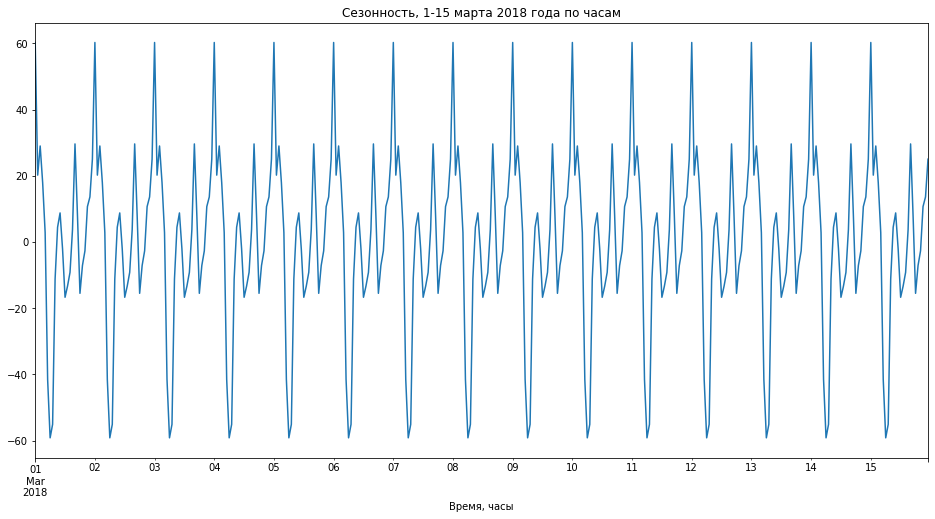

In [11]:
plt.figure(figsize=(16, 8))
decomposed.seasonal['2018-03-01':'2018-03-15'].plot(ax=plt.gca())
plt.xlabel('Время, часы')
plt.title('Сезонность, 1-15 марта 2018 года по часам')
plt.show()

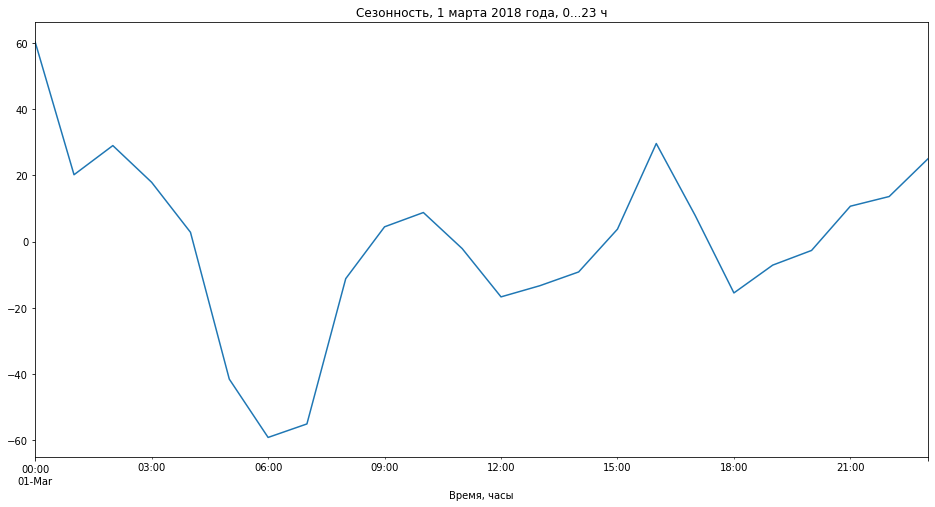

In [12]:
plt.figure(figsize=(16, 8))
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-01 23:00:00'].plot(ax=plt.gca())
plt.xlabel('Время, часы')
plt.title('Сезонность, 1 марта 2018 года, 0...23 ч')
plt.show()

По первой половине марта видно, что изменения количества заказов в течение дня очень похожи изо дня в день:
- спад в ночное время с минимумом около 6 утра (прилёты в ночное время наименее удобны);
- затем рост с локальными максимумами около 10 ч утра и 16 ч дня (удобное время прилёта: в первом случае - ранний так, чтобы весь день прошёл в стране прилёта, во втором случае - комфортный вылет в первой половине дня);
- максимум заказов - около полуночи (снова удобное время прилёта - по максимуму провести день в стране вылета).

Посмотрим, есть ли какие-то закономерности по дням.

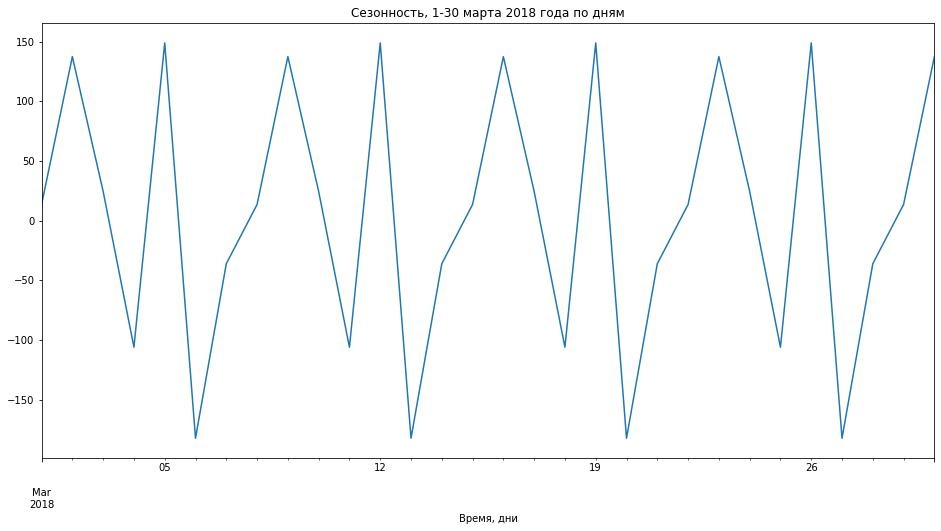

In [13]:
decomposed_day = seasonal_decompose(df['num_orders'].resample('1D').sum())

plt.figure(figsize=(16, 8))
decomposed_day.seasonal['2018-03-01':'2018-03-30'].plot(ax=plt.gca())
plt.xlabel('Время, дни')
plt.title('Сезонность, 1-30 марта 2018 года по дням')
plt.show()

Наибольшее число заказов приходится на понедельники и пятницы, наименьшее - на воскресенья и вторники. Здесь тоже прослеживается логика прилётов: максимум либо в начале рабочей недели, либо перед выходными.

### 2.1 Вывод
В данных присутствует тренд увеличения числа заказов к концу рассматриваемого периода.

Изменения количества заказов в течение дня очень похожи изо дня в день:
- спад в ночное время с минимумом около 6 утра;
- затем рост с локальными максимумами около 10 ч утра и 16 ч дня;
- максимум заказов - около полуночи.

Также присутствует недельная повторяемость: наибольшее число заказов приходится на понедельники и пятницы, наименьшее - на воскресенья и вторники.


## 3 Обучение моделей

### 3.1 Подготовка признаков

Мы выявили, что в данных присутствует сезонность по дням недели и по времени суток. Поэтому в данные следует добавить эти характеристики. Напишем функцию для создания и добавления в таблицу новых признаков:
- час;
- день недели;
- отстающие значения;
- скользящее среднее.

In [14]:
def make_features(data, max_lag, rolling_mean_size):
  '''
  функция для создания новых признаков: принимает на вход таблицу с данными,
  максимальный размер отставания, ширину окна скользящего среднего.
  Возвращает копию исходной таблицы с новыми признаками 
  '''
  dfc = data.copy(deep=True)
  dfc['hour'] = dfc.index.hour
  dfc['dayofweek'] = dfc.index.dayofweek
    
  for lag in range(1, max_lag + 1):
    dfc['lag_{}'.format(lag)] = dfc['num_orders'].shift(lag)

  dfc['rolling_mean'] = dfc['num_orders'].shift().rolling(rolling_mean_size).mean()

  return dfc

In [15]:
# получение копии исходной таблицы с новыми признаками
dfc = make_features(df, 4, 24)
dfc.head()

,num_orders,rolling_mean,hour,dayofweek,lag_1,lag_2,lag_3,lag_4
datetime,,,,,,,,
2018-03-01 00:00:00,124,NaN,0,3,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,1,3,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,2,3,85.0,124.0,NaN,NaN
2018-03-01 03:00:00,66,NaN,3,3,71.0,85.0,124.0,NaN
2018-03-01 04:00:00,43,NaN,4,3,66.0,71.0,85.0,124.0


Копия исходной таблицы с новыми признаками получена. Теперь разделим её на обучающую и тестовую выборки в соотношении 90:10.

In [16]:
# разделение таблицы на обучающую и тестовую выборки
train, test = train_test_split(dfc, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
 
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

display(train.index.min(), train.index.max())
display(test.index.min(), test.index.max())
display(f'Размер признаков обучающей выборки: {features_train.shape}')
display(f'Размер целевого признака обучающей выборки: {target_train.shape}')
display(f'Размер признаков тестовой выборки: {features_test.shape}')
display(f'Размер целевого признака тестовой выборки: {target_test.shape}')

Timestamp('2018-03-02 00:00:00', freq='H')

Timestamp('2018-08-13 13:00:00', freq='H')

Timestamp('2018-08-13 14:00:00', freq='H')

Timestamp('2018-08-31 23:00:00', freq='H')

'Размер признаков обучающей выборки: (3950, 7)'

'Размер целевого признака обучающей выборки: (3950,)'

'Размер признаков тестовой выборки: (442, 7)'

'Размер целевого признака тестовой выборки: (442,)'

Разделение корректное.

Для линейной регрессии дополнительно произведём масштабирование признаков.

In [17]:
# переменная, содержащая количественные признаки
numeric = ['rolling_mean', 'hour', 'dayofweek',
           'lag_1', 'lag_2', 'lag_3', 'lag_4']

# создание копий признаков для масштабирования
features_train_lr = features_train.copy(deep=True)
features_test_lr = features_test.copy(deep=True)

# масштабирование признаков
scaler = StandardScaler()

scaler.fit(features_train[numeric])

features_train_lr[numeric] = scaler.transform(features_train[numeric])
features_test_lr[numeric] = scaler.transform(features_test[numeric])

display(features_train_lr.head(3))
display(features_test_lr.head(3))

,rolling_mean,hour,dayofweek,lag_1,lag_2,lag_3,lag_4
datetime,,,,,,,
2018-03-02 00:00:00,-1.106319,-1.659179,0.48532,-0.527564,0.894187,-0.320444,-0.449344
2018-03-02 01:00:00,-1.179778,-1.514680,0.48532,0.299761,-0.527656,0.895012,-0.319978
2018-03-02 02:00:00,-1.104159,-1.370181,0.48532,1.075379,0.299598,-0.527331,0.896068


,rolling_mean,hour,dayofweek,lag_1,lag_2,lag_3,lag_4
datetime,,,,,,,
2018-08-13 14:00:00,3.130539,0.363809,-1.507418,1.049525,0.351302,1.696696,2.008621
2018-08-13 15:00:00,3.126218,0.508308,-1.507418,0.610008,1.049298,0.351936,1.698141
2018-08-13 16:00:00,3.182392,0.652807,-1.507418,2.497344,0.609819,1.050177,0.352729


Подготовка признаков произведена, приступим к обучению разных моделей и выбору лучшей.

### 3.2 Линейная регрессия

In [18]:
%%time
# инициализация модели линейной регрессии
model_lr = LinearRegression()

# установка диапазонов гиперпараметров
param_lr = {}

# установка хронологического разбиения
tsc = TimeSeriesSplit(n_splits=4)

# поиск лучших гиперпараметров
grid_lr = GridSearchCV(model_lr, param_lr,
                        scoring='neg_root_mean_squared_error',
                        cv=tsc, n_jobs=-1)

# обучение модели
grid_lr.fit(features_train_lr, target_train)

# выбор лучшей модели
best_model_lr = grid_lr.best_estimator_

display('Лучшее значение RMSE:', grid_lr.cv_results_['mean_test_score'])

'Лучшее значение RMSE:'

array([-31.95719094])

Wall time: 4.55 s


### 3.3 Дерево решений

In [19]:
%%time
# инициализация модели дерева решений 
model_dt = DecisionTreeRegressor(random_state = 12345)

# установка диапазонов гиперпараметров
param_dt = {'max_depth': range(7, 11)}

# поиск лучших гиперпараметров    
grid_dt = GridSearchCV(model_dt, param_dt,
                        scoring='neg_root_mean_squared_error',
                        cv=tsc, n_jobs=-1)

# обучение модели
grid_dt.fit(features_train, target_train)

# выбор лучшей модели
best_model_dt = grid_dt.best_estimator_

display('Лучшее значение RMSE:', grid_dt.best_score_)
display('Лучшие параметры', grid_dt.best_params_)

'Лучшее значение RMSE:'

-30.358988663615847

'Лучшие параметры'

{'max_depth': 9}

Wall time: 271 ms


### 3.4 Случайный лес

In [20]:
%%time
# инициализация модели случайного леса
model_rf = RandomForestRegressor(random_state = 12345)

# установка диапазонов гиперпараметров
param_rf = {'n_estimators': [100, 200],
            'max_depth': range(10, 21, 5)}

# поиск лучших гиперпараметров    
grid_rf = GridSearchCV(model_rf, param_rf,
                        scoring='neg_root_mean_squared_error',
                        cv=tsc, n_jobs=-1)

# обучение модели
grid_rf.fit(features_train, target_train)

# выбор лучшей модели
best_model_rf = grid_rf.best_estimator_

display('Лучшее значение RMSE:', grid_rf.best_score_)
display('Лучшие параметры', grid_rf.best_params_)

'Лучшее значение RMSE:'

-26.552614104995342

'Лучшие параметры'

{'max_depth': 15, 'n_estimators': 200}

Wall time: 16.1 s


### 3.5 CatBoostRegressor

In [21]:
%%time
# создание объекта для модели
cbr = CatBoostRegressor(iterations=100)

# установка параметров
param_cbr = {'depth': range(2, 6),
             'learning_rate': [0.2, 0.3]}

# поиск лучших параметров
grid_cbr = GridSearchCV(estimator=cbr, param_grid=param_cbr,
                        scoring='neg_root_mean_squared_error', cv=tsc, n_jobs=-1)

# обучение модели
grid_cbr.fit(features_train, target_train, verbose=10)

# выбор лучшей модели
best_model_cbr = grid_cbr.best_estimator_

display('Лучшее значение RMSE:', grid_cbr.best_score_)
display('Лучшие параметры', grid_cbr.best_params_)

0:	learn: 35.3609033	total: 95.6ms	remaining: 9.46s
10:	learn: 26.1404761	total: 135ms	remaining: 1.09s
20:	learn: 24.6002301	total: 154ms	remaining: 581ms
30:	learn: 23.7545420	total: 172ms	remaining: 382ms
40:	learn: 23.0415498	total: 188ms	remaining: 271ms
50:	learn: 22.3794724	total: 204ms	remaining: 196ms
60:	learn: 21.6980143	total: 221ms	remaining: 141ms
70:	learn: 21.1581727	total: 237ms	remaining: 97ms
80:	learn: 20.7446594	total: 253ms	remaining: 59.5ms
90:	learn: 20.4295033	total: 270ms	remaining: 26.7ms
99:	learn: 20.1577347	total: 285ms	remaining: 0us


'Лучшее значение RMSE:'

-26.563617576338274

'Лучшие параметры'

{'depth': 4, 'learning_rate': 0.2}

Wall time: 3.44 s


### 3.6 Вывод
Для обучения моделей созданы и добавлены в данные новые признаки:
- час;
- день недели;
- отстающие значения;
- скользящее среднее.

Дополнительно произведено масштабирование признаков для линейной регрессии.

Построены и обучены модели линейной регрессии, дерева решений, случайного леса, градиентного бустинга *CatBoostRegressor*.

Лучшие значения *RMSE* на обучающей выборке получены случайным лесом (26,55) и *CatBoostRegressor* (26,56), поэтому на тестовой выборке проверим обе модели.

## 4 Тестирование

Получим значения *RMSE* на тестовой выборке для лучших выбранных моделей случайного леса и *CatBoostRegressor*.

In [22]:
%%time
# получение предсказаний на тестовой выборке случайным лесом
predict_rf = best_model_rf.predict(features_test)
# расчёт RMSE для случайного леса
rmse_rf = mean_squared_error(target_test, predict_rf, squared=False)
display('RMSE случайного леса:', rmse_rf)

'RMSE случайного леса:'

47.27648154811074

Wall time: 50 ms


In [23]:
%%time
# получение предсказаний на тестовой выборке CatBoostRegressor
predict_cbr = best_model_cbr.predict(features_test)
# расчёт RMSE для CatBoostRegressor
rmse_cbr = mean_squared_error(target_test, predict_cbr, squared=False)
display('RMSE CatBoostRegressor:', rmse_cbr)

'RMSE CatBoostRegressor:'

46.82191640530908

Wall time: 20 ms


Лучшее значение *RMSE* на тестовой выборке получено моделью градиентного бустинга *CatBoostRegressor* - 46,82. Величина удовлетворяет поставленному условию (должна быть не больше 48).

Построим график по предсказаниям *CatBoostRegressor* и значениям целевого признака тестовой выборки для наглядности качества предсказаний. Для визуализации возьмём первые двое суток тестовой выборки.

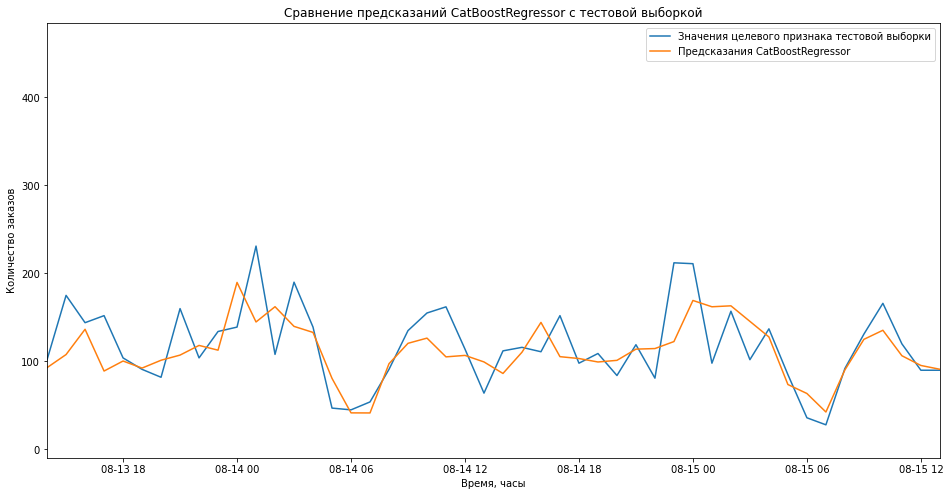

In [24]:
plt.figure(figsize=(16, 8))

plt.plot(target_test, label='Значения целевого признака тестовой выборки')
plt.plot(target_test.index, predict_cbr, label='Предсказания CatBoostRegressor')
plt.xlim(pd.Timestamp('2018-08-13 14:00:00'), pd.Timestamp('2018-08-15 13:00:00'))
plt.xlabel('Время, часы')
plt.ylabel('Количество заказов')
plt.title('Сравнение предсказаний CatBoostRegressor с тестовой выборкой')
plt.legend()
plt.show()

По графику видно, что предсказания менее подвержены колебаниям, вследствие чего иногда не попадают в резкое увеличение количества заказов. Вместе с тем, на протяжении двух дней качество предсказания приблизительно одинаковое.

### 4.1 Вывод
Лучшее значение *RMSE* на тестовой выборке получено моделью градиентного бустинга *CatBoostRegressor* - 46,82. Величина удовлетворяет поставленному условию (должна быть не больше 48).

Сравнение предсказаний *CatBoostRegressor* и значений целевого признака тестовой выборки на графике показало, что предсказания менее подвержены колебаниям. Вместе с тем, на протяжении двух дней качество предсказания приблизительно одинаковое.

## 5 Общий вывод
1. Для исследования представлены исторические данные о заказах такси в аэропортах.

- Произведено ресемплирование данных по одному часу, после чего получено для работы получено 4416 объектов - информация о часовых количествах заказов такси.
- Даты и время расположены в хронологическом порядке, тип данных соответствует содержимому по смыслу, пропусков нет.
- Минимальное число заказов - 0, максимальное - 462, значения правдоподобны.
- В данных представлена информация с 0 часов 1 марта до 23 часов 31 августа 2018 года, т.е. за полгода.

2. В данных присутствует тренд увеличения числа заказов к концу рассматриваемого периода.

Изменения количества заказов в течение дня очень похожи изо дня в день:
- спад в ночное время с минимумом около 6 утра;
- затем рост с локальными максимумами около 10 ч утра и 16 ч дня;
- максимум заказов - около полуночи.

Также присутствует недельная повторяемость: наибольшее число заказов приходится на понедельники и пятницы, наименьшее - на воскресенья и вторники.

3. Для обучения моделей созданы и добавлены в данные новые признаки:
- час;
- день недели;
- отстающие значения;
- скользящее среднее.

Дополнительно произведено масштабирование признаков для линейной регрессии.

Построены и обучены модели линейной регрессии, дерева решений, случайного леса, градиентного бустинга *CatBoostRegressor*.

Лучшие значения *RMSE* на обучающей выборке получены случайным лесом (26,55) и *CatBoostRegressor* (26,56), поэтому на тестовой выборке проверены обе модели.

4. Лучшее значение *RMSE* на тестовой выборке получено моделью градиентного бустинга *CatBoostRegressor* - 46,82. Величина удовлетворяет поставленному условию (должна быть не больше 48).

Сравнение предсказаний *CatBoostRegressor* и значений целевого признака тестовой выборки на графике показало, что предсказания менее подвержены колебаниям. Вместе с тем, на протяжении двух дней качество предсказания приблизительно одинаковое.

5. Прогнозирование количества заказов такси на следующий час для привлечения большего числа водителей в период пиковой нагрузки рекомендуется использовать модель градиентного бустинга *CatBoostRegressor* с максимальной глубиной дерева, равной 4, со скоростью обучения 0,2 и количеством деревьев в ансамбле, равным 100.